In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

2023-03-04 21:59:43.120461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 21:59:43.267862: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-04 21:59:43.725799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-04 21:59:43.725869: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))


class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

train.shape = 94477 rows, 4 cols


In [3]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [4]:
def load_frames(
    frames_data,
    max_frames: int = 20,
    crop_method: str = 'nearest',
    get_masks: bool = True,
):
    '''Take frames data shape=(n_frames, pts, dims) to fixed num of frames.
    
    - Pads data with fewer frames with zeros
    - Reduces max number of allowed frames by crop method:
        * 'nearest' (default): 
    '''
    
    if len(frames_data) < max_frames:
        diff = max_frames - len(frames_data)
        padding = np.zeros((diff, 543, 3))
        frames = np.concatenate((frames_data, padding))
        if get_masks:
            # Only mask the padding
            masks = np.zeros(shape=(1, max_frames,), dtype='bool')
            masks[0,:len(frames_data)] = 1
            
    else:
        if crop_method == 'nearest':
            frames = tf.image.resize(
                frames_data,
                (max_frames, 543),
                method='nearest',
            ).numpy()
        elif crop_method == 'cut':
            frames = frames_data[:max_frames]
        else:
            raise Exception(f'{crop_method=} not found')
        if get_masks:
            # Use all the frames
            masks = np.ones(shape=(1, max_frames,), dtype='bool')

    if get_masks:
        return frames, masks
    else:
        return frames

In [5]:
def compress_frames(frames):
    '''Make a video of shape (n_frames, pts, dims) --> (n_frames, pts*dims) '''
    n_frames = frames.shape[0]
    columns = frames.shape[1]*frames.shape[2]
    return frames.reshape(n_frames, columns)

In [6]:
# Hyperparams
MAX_FRAMES = 20
MAX_SEQ_LENGTH = MAX_FRAMES
N_PTS = 543
N_DIMS = 3
NUM_FEATURES = N_PTS*N_DIMS

X_npy_fname = f'X-{MAX_FRAMES}_frames-pts_flattened.npy'
y_npy_fname = f'y.npy'
masks_fname = f'all_masks-{MAX_FRAMES}.npy'

if CFG.is_training:
    try:
        X = np.load(X_npy_fname)
        All_masks = np.load(masks_fname)
        y = np.load(y_npy_fname)
    except:
        X = np.zeros((len(train), MAX_FRAMES, N_PTS*N_DIMS))
        All_masks = np.zeros(shape=(len(train), MAX_FRAMES), dtype='bool')
        y = np.zeros((len(train),))
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            frames_reduced, masks = load_frames(data, max_frames=MAX_FRAMES)
            data_resize = compress_frames(frames_reduced)
            X[i] = data_resize
            All_masks[i] = masks
            y[i] = train.iloc[i].label
            num_frames[i] = data.shape[0]
        ## Save number of frames of each training sample for data analysis
        train['num_frames'] = num_frames
        print(train['num_frames'].describe())
        train.to_csv('train.csv', index=False)
        np.save(X_npy_fname, X)
        np.save(y_npy_fname, y)
        np.save(masks_fname, All_masks)

    print(X.shape, y.shape)

(94477, 20, 1629) (94477,)


In [7]:
All_masks.shape

(94477, 20)

In [8]:
# TODO: Make All_masks as part of split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# RNN Model

> https://keras.io/examples/vision/video_classification/

In [9]:
# Utility for our sequence model.
def get_sequence_model(max_frames: int, num_features: int):
    n_classes = 250

    frame_features_input = tf.keras.Input((max_frames, num_features))
    mask_input = tf.keras.Input((max_frames,), dtype='bool')

    # Why `mask`: https://keras.io/api/layers/recurrent_layers/gru/
    x = tf.keras.layers.GRU(32, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = tf.keras.layers.GRU(16)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    rnn_model = tf.keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    return rnn_model

In [10]:
def run_experiment(
    model,
    train_data,
    train_labels,
    validation_data = None,
    validation_split: int = 0.2,
    model_path: str = 'temp',
    epochs: int = 10,
    batch_size: int = 128,
    monitor_metric: str = 'val_accuracy',
    patience: int = 6,
):
    print(model.summary())
    checkpoint = [
        tf.keras.callbacks.ModelCheckpoint(
            model_path,
            save_weights_only=True,
            save_best_only=True,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
        ),
    ]
        
    fit_params = dict(
        x=train_data,
        y=train_labels,
        epochs=epochs,
        batch_size=batch_size,
    )
    if validation_data:
        fit_params['validation_data'] = validation_data
    else:
        fit_params['validation_split'] = validation_split

    history = model.fit(
        **fit_params,
        callbacks=checkpoint,
    )

    return model, history

## Experiment

In [11]:
model = get_sequence_model(max_frames=MAX_FRAMES, num_features=NUM_FEATURES)

2023-03-04 21:59:49.644970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 21:59:49.650575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 21:59:49.650800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 21:59:49.651400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1629)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 32)       159648      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 16)           2400        ['gru[0][0]']                

In [13]:
model, history = run_experiment(
    model=model,
    train_data=[X, All_masks],
    train_labels=y,
    validation_split=0.2,
    model_path='model_test-rnn.h5',
    batch_size=32,
    epochs=200,
    patience=8,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1629)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 32)       159648      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 16)           2400        ['gru[0][0]']                

2023-03-04 21:59:53.202408: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9849715920 exceeds 10% of free system memory.
2023-03-04 21:59:57.439031: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9849715920 exceeds 10% of free system memory.


Epoch 1/200


2023-03-04 22:00:04.027652: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'
2023-03-04 22:00:04.661381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-04 22:00:05.454788: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2362/2362 [==============================] - 34s 12ms/step - loss: 5.5126 - accuracy: 0.0047 - val_loss: 5.4952 - val_accuracy: 0.0050
Epoch 2/200
2362/2362 [==============================] - 25s 11ms/step - loss: 5.4835 - accuracy: 0.0056 - val_loss: 5.4831 - val_accuracy: 0.0051
Epoch 3/200
2362/2362 [==============================] - 25s 10ms/step - loss: 5.4103 - accuracy: 0.0077 - val_loss: 5.3279 - val_accuracy: 0.0092
Epoch 4/200
2362/2362 [==============================] - 25s 11ms/step - loss: 5.2696 - accuracy: 0.0122 - val_loss: 5.2587 - val_accuracy: 0.0139
Epoch 5/200
2362/2362 [==============================] - 25s 11ms/step - loss: 5.1502 - accuracy: 0.0184 - val_loss: 5.1217 - val_accuracy: 0.0210
Epoch 6/200
2362/2362 [==============================] - 25s 11ms/step - loss: 5.0223 - accuracy: 0.0256 - val_loss: 4.9887 - val_accuracy: 0.0293
Epoch 7/200
2362/2362 [==============================] - 25s 11ms/step - loss: 4.9293 - accuracy: 0.0305 - val_loss: 4.8859 - val_

2362/2362 [==============================] - 25s 11ms/step - loss: 3.1927 - accuracy: 0.2585 - val_loss: 3.3144 - val_accuracy: 0.2510
Epoch 57/200
2362/2362 [==============================] - 26s 11ms/step - loss: 3.1877 - accuracy: 0.2603 - val_loss: 3.5952 - val_accuracy: 0.2015
Epoch 58/200
2362/2362 [==============================] - 26s 11ms/step - loss: 3.1750 - accuracy: 0.2617 - val_loss: 3.3145 - val_accuracy: 0.2538
Epoch 59/200
2362/2362 [==============================] - 25s 11ms/step - loss: 3.1638 - accuracy: 0.2655 - val_loss: 3.3175 - val_accuracy: 0.2502
Epoch 60/200
2362/2362 [==============================] - 26s 11ms/step - loss: 3.1541 - accuracy: 0.2662 - val_loss: 3.5442 - val_accuracy: 0.2122
Epoch 61/200
2362/2362 [==============================] - 26s 11ms/step - loss: 3.1442 - accuracy: 0.2659 - val_loss: 3.3610 - val_accuracy: 0.2394
Epoch 62/200
2362/2362 [==============================] - 27s 11ms/step - loss: 3.1302 - accuracy: 0.2728 - val_loss: 3.2541 

### Plot Results

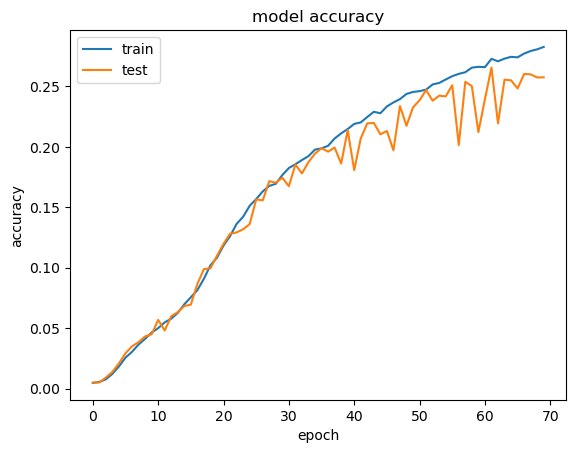

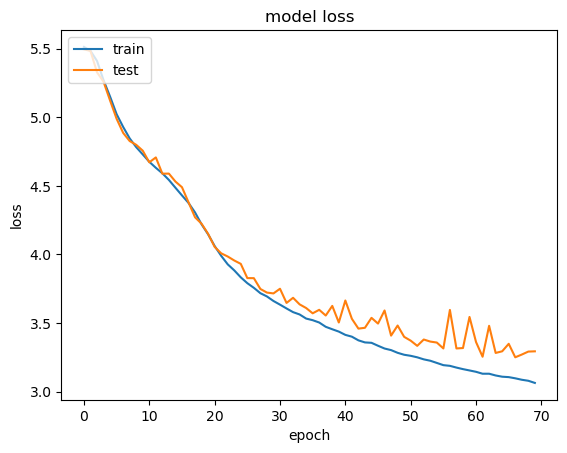

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()